### Exercise 10.1

In [6]:
import numpy as np
import sys
from matplotlib import pyplot as plt
ROOTDIR = '/home/lochy/Documents/Subject/ucd_geology/Gel298_winter/jupyter_notebooks'
sys.path.append('%s/python_scripts' % ROOTDIR)
from GMesh2d import MESH2D
from GHeatConservationSolver import EXPLICIT_SOLVER

#### Define the explicit solver

The explicit solver is formulated in one time step by eq 10.3 from the textbook:

$$ T_3 = T_3^0 + \frac{k \Delta t}{\rho C_p}\left(\frac{T_1^0 - 2 T_3^0 - T_5^0}{{\Delta x}^2} + \frac{T_2^0 - 2 T_3^0 - T_4^0}{{\Delta y}^2}\right)$$

Here are the position of the stencils

![](./stencil_energy_conservation.PNG.jpg)

#### Initiate a 2d mesh

This MESH2D class is defined in "python_scripts/GMesh2d.py". 
Here, we use a regular grid of 51 × 31 points. The model size is 1000 × 1500 km2 (i.e. 1 000 000 × 1 500 000 m2). 

In [7]:
# initiate mesh
xsize = 1000000.0 # Model size, m
ysize = 1500000.0
xnum = 21   # Number of nodes
ynum = 31
xs = np.linspace(0.0, xsize, xnum) # construct xs 
ys = np.linspace(0.0, ysize, ynum) # construct ys
Mesh2d = MESH2D(xs, ys)

#### Read in the initial temperature

The initial setup corresponds to a background temperature of 1000 K with a rectangular thermal wave (1300 K) in the middle (‘wave’ means sharp perturbation of the temperature field).

(31, 21)


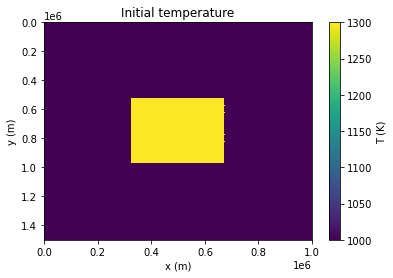

In [8]:
# initial temperature
def rectangular_wave_temperature(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        T = 1300.0
      else:
        T = 1000.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      T = np.ones(x.shape) * 1000.0
      T[mask] = 1300.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return T

xxs, yys = np.meshgrid(xs, ys)
Ts_init = rectangular_wave_temperature(xxs, yys, xsize, ysize)
print(Ts_init.shape)  # debug

# plot
fig, ax = plt.subplots()
h = ax.pcolor(xxs, yys, Ts_init)
ax.set_title('Initial temperature')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim([0.0, xsize])
ax.set_ylim([0.0, ysize])
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label='T (K)')

#### Solve the problem

An explicit FD is used with Eq (10.4) from the textbook. 
Use constant thermal conductivity k = 3 W/(m K), density ρ = 3200 kg/m 3 and heat capacity CP = 1000 J/(kg K) for the entire model. 

The limit of time step is given by $t_m = \frac{\Delta x^2}{2\kappa}$, thus we first output this value below.

In [9]:
year = 365 * 24 * 3600.0
thermal_conductivity = 3
rho = 3200.0
cp = 1000.0
kappa = thermal_conductivity / rho / cp  # thermal diffusivity
dt_m = (xsize / (xnum-1.0))**2.0 / (2*kappa)
print("Limit on time step: %.4e year" % (dt_m / year))

Limit on time step: 4.2280e+07 year


With this estimation, we first test a scenario where the time increment is choosen as $0.6 t_m$

Temperature solver: 1.1678e-03 s to solver
Temperature solver: 3.9601e-04 s to solver
Temperature solver: 3.8195e-04 s to solver
Temperature solver: 3.7861e-04 s to solver
Temperature solver: 4.0770e-04 s to solver
Temperature solver: 3.9363e-04 s to solver
Temperature solver: 3.9172e-04 s to solver
Temperature solver: 3.8552e-04 s to solver
Temperature solver: 3.9911e-04 s to solver
Temperature solver: 3.9124e-04 s to solver
Temperature solver: 3.9840e-04 s to solver
Temperature solver: 3.8338e-04 s to solver
Temperature solver: 3.9124e-04 s to solver
Temperature solver: 4.1604e-04 s to solver
Temperature solver: 3.8409e-04 s to solver
Temperature solver: 3.7551e-04 s to solver
Temperature solver: 3.8671e-04 s to solver
Temperature solver: 3.8981e-04 s to solver
Temperature solver: 3.7432e-04 s to solver
Temperature solver: 3.8743e-04 s to solver


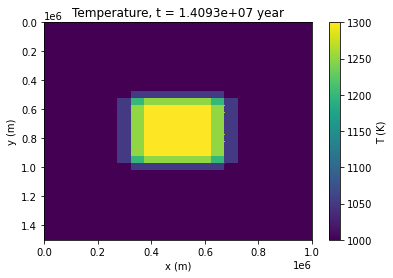

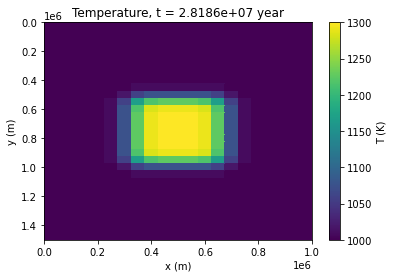

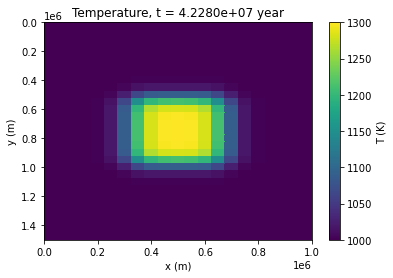

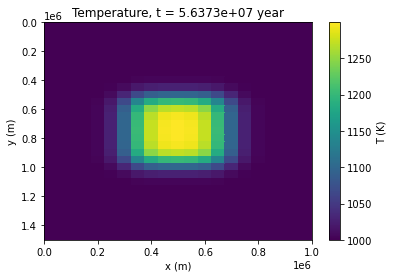

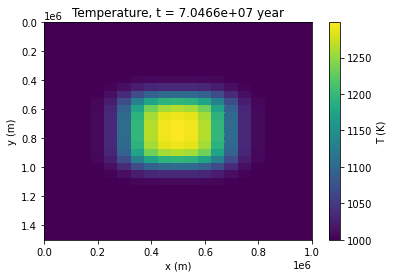

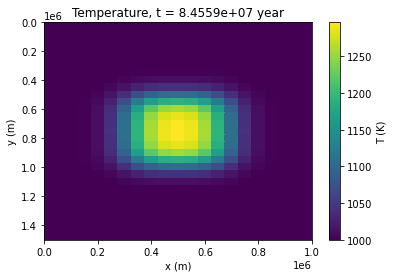

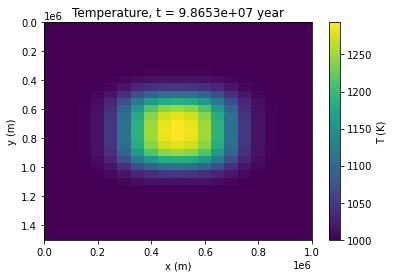

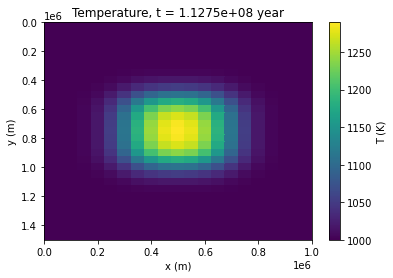

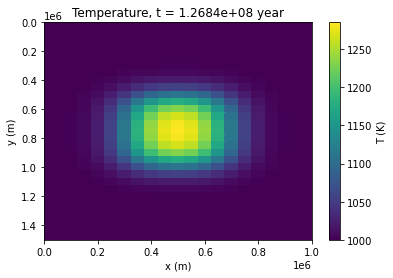

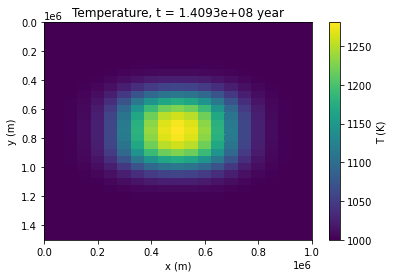

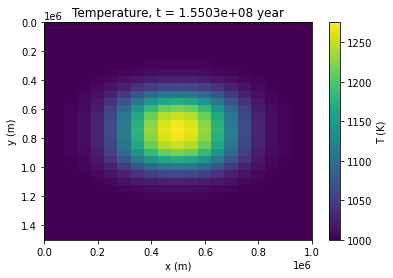

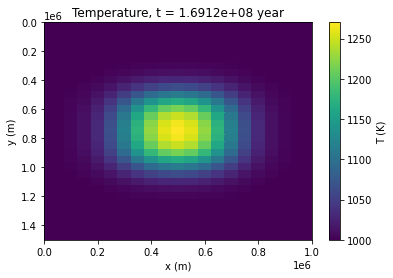

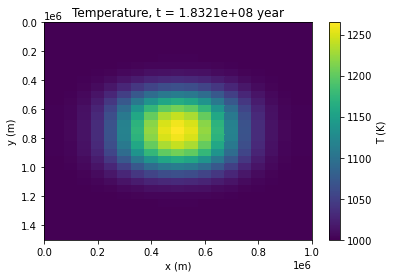

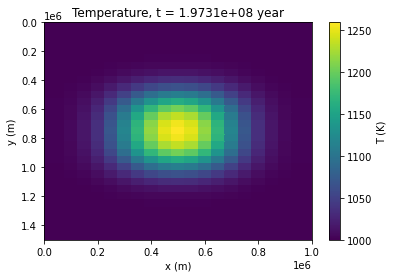

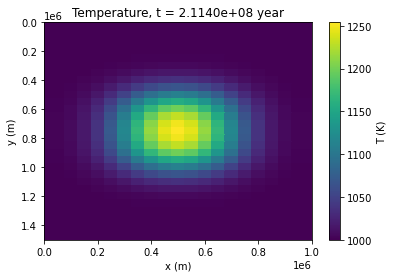

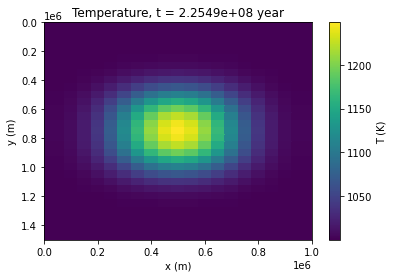

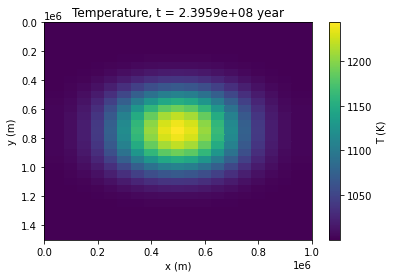

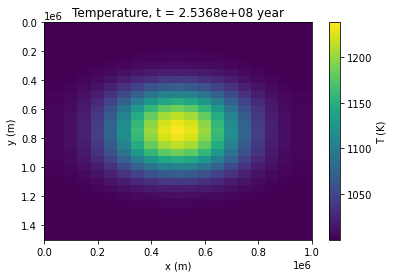

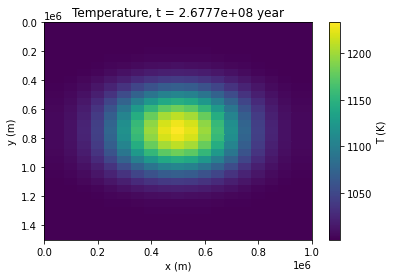

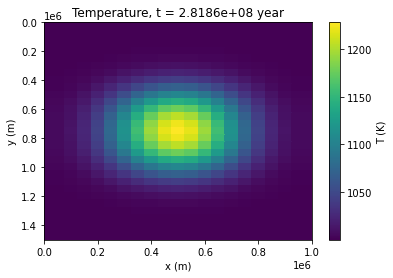

In [10]:
dt = dt_m / 3.0  # what Geyra used in his script.
# dt = 1.0  # debug: with this, the temperature profile should be the initial profile
total_step = 20
# initiate solver
HCSolver = EXPLICIT_SOLVER(Mesh2d, use_constant_thermal_conductivity=True)
HCSolver.initial_temperature(Ts_init)  # use the rectangular perturbation as the initial temperature

for step in range(total_step):
    # assemble and solve
    HCSolver.assemble(thermal_conductivity, rho, cp, dt)
    HCSolver.solve()
    # export and plot
    xxs, yys, Ts = HCSolver.export()
    t = HCSolver.get_time()
    fig, ax = plt.subplots()
    h = ax.pcolor(xxs, yys, Ts)
    ax.set_title('Temperature, t = %.4e year' % (t/year))
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([0.0, xsize])
    ax.set_ylim([0.0, ysize])
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='T (K)')